### Задание 5.3

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [2]:
# импортируем необходимые библиотеки

import pandas as pd
#import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [67]:
# Подключение БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator'
}

# SQL Запрос на получение необходимых данных из БД
'''Учитывая, что в задании 5.3 конкретного периода за который необходимо формировать выборки нет,
но есть группы, которые необходимо сравнить (0 и 3; 1 и 2). Смею предположить, что период аналогичный 
заданию 5.2
'''

query = '''
SELECT 
  exp_group,
  user_id,
  COUNT(action) FILTER (WHERE action = 'like') AS "likes",
  COUNT(action) FILTER (WHERE action = 'view') AS "views",
  COUNT(action) FILTER (WHERE action = 'like') /
  COUNT(action) FILTER (WHERE action = 'view') AS "CTR"
FROM 
  simulator_20230120.feed_actions
WHERE 
  exp_group IN (0, 1, 2, 3)
  AND DATE(time) BETWEEN '2023-01-01' AND '2023-01-07'
GROUP BY 
  exp_group,
  user_id
'''

In [68]:
# Датафрейм из полученных данных

df = pandahouse.read_clickhouse(query=query, connection=connection)

In [3]:
df = pd.read_csv('data_for_5.3.csv')

In [69]:
# Создадим два датафрейма для сравнения соответствующих групп

df_0_3 = df[(df.exp_group == 0) | (df.exp_group == 3)]
df_1_2 = df[(df.exp_group == 1) | (df.exp_group == 2)]

Для сравнения групп между собой, необходимо использовать поюзерную метрику линеаризованных лайков. Которая рассчитывается по формуле: 

LL=likes-CTR(в контрольной группе) * views.

Так как в формуле участвует CTR контрольной группы, рассчитаем его (контрольными группами являются 0 и 1).

In [71]:
# CTR для каждой из контрольных групп, запищим в соответствующие переменные.

CTR0 = df_0_3.likes[df_0_3.exp_group == 0].sum() / df_0_3.views[df_0_3.exp_group == 0].sum()
CTR1 = df_1_2.likes[df_1_2.exp_group == 1].sum() / df_1_2.views[df_1_2.exp_group == 1].sum()

In [72]:
# Напишим функцию, которая будет считать метрику по заданной формуле.

def lin_likes(row):
    if row[0] in (0, 3):
        return row[2] - CTR0 * row[3]
    else:
        return row[2] - CTR1 * row[3]

In [73]:
# С помощью функции посчитаем линеаризованные лайки для каждого пользователя в датафреймах.

df_1_2['linearized_likes'] = df_1_2.apply(lambda x: lin_likes(x), axis=1)
df_0_3['linearized_likes'] = df_0_3.apply(lambda x: lin_likes(x), axis=1)

/tmp/ipykernel_45/4161973054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_2['linearized_likes'] = df_1_2.apply(lambda x: lin_likes(x), axis=1)
/tmp/ipykernel_45/4161973054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_3['linearized_likes'] = df_0_3.apply(lambda x: lin_likes(x), axis=1)


Проанализируем t-тестом различия в выборках у 0 и 3 группы по мертрике линеаризованных лайков.

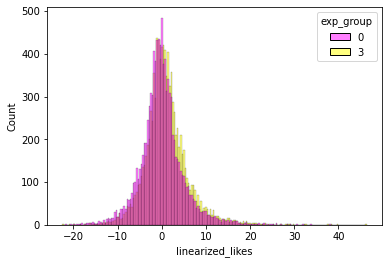

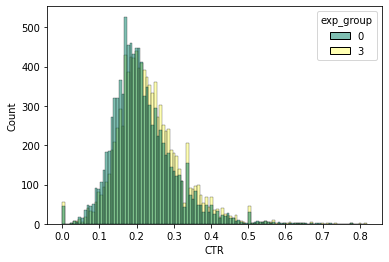

In [74]:
# Построим частотные графики интересующих нас метрик.

sns.histplot(x=df_0_3.linearized_likes, hue=df_0_3.exp_group, palette='spring')
plt.show()
sns.histplot(x=df_0_3.CTR, hue=df_0_3.exp_group, palette='summer')
plt.show()

In [75]:
# t-тест по линеаризованным лайкам и CTR

st, pv = stats.ttest_ind(df_0_3.linearized_likes[df_0_3.exp_group == 0],
                df_0_3.linearized_likes[df_0_3.exp_group == 3],
                equal_var=False)
st1, pv1 = stats.ttest_ind(df_0_3.CTR[df_0_3.exp_group == 0],
                df_0_3.CTR[df_0_3.exp_group == 3],
                equal_var=False)
print(f'P-value в первом случае = {pv};\n\
p-value во втором случае = {pv1}.')

P-value в первом случае = 5.4914249479690016e-52;
p-value во втором случае = 1.055849414662529e-43.


В обоих случаях p-value очень мал, значительно меньше α = 0.05, что позволяет отколонить нулевую гипотезу о равенстве средних значений между выборками. Но стоит признать, что в случает с линеаризованными лайками p-value оказался меньше.

Так как мы хотим заметить увеличение показателя, можно использовать одностороннюю гипотезу: 
- Н0 - показатель в группе 3 <= показателю в группе 0; 
- Н1 - показатель в группе 3 > показателя в группе 0.

In [59]:
st, pv = stats.ttest_ind(df_0_3.linearized_likes[df_0_3.exp_group == 3],
                         df_0_3.linearized_likes[df_0_3.exp_group == 0],
                         equal_var=False, alternative='greater')
st1, pv1 = stats.ttest_ind(df_0_3.CTR[df_0_3.exp_group == 3],
                           df_0_3.CTR[df_0_3.exp_group == 0],
                           equal_var=False, alternative='greater')
print(f'P-value в первом случае = {pv};\n\
p-value во втором случае = {pv1}.')

P-value в первом случае = 2.7457124739845008e-52;
p-value во втором случае = 5.279247073312645e-44.


Результаты в обоих случаях позволяют отвергнуть Н0 и принять альтернативную гипотезу о том, что значение в группе 3 больше, чем в группе 0. При этом p-value с линеаризованными лайками снова оказался меньше.

Теперь, аналогичным образом проанализируем t-тестом различия в выборках у 1 и 2 группы по мертрике линеаризованных лайков.

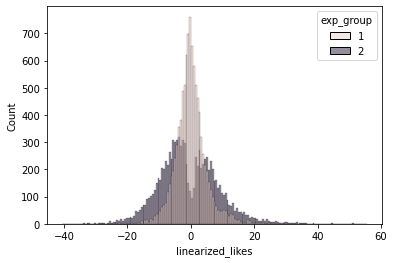

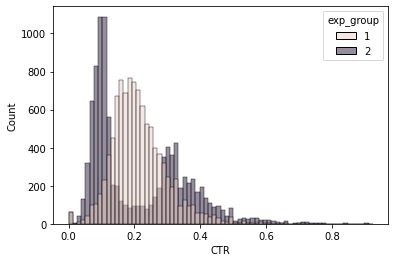

In [76]:
sns.histplot(x=df_1_2.linearized_likes, hue=df_1_2.exp_group)
plt.show()
sns.histplot(x=df_1_2.CTR, hue=df_1_2.exp_group)
plt.show()

In [77]:
# t-тест по линеаризованным лайкам и CTR

st, pv = stats.ttest_ind(df_1_2.linearized_likes[df_1_2.exp_group == 1],
                         df_1_2.linearized_likes[df_1_2.exp_group == 2],
                         equal_var=False)
st1, pv1 = stats.ttest_ind(df_1_2.CTR[df_1_2.exp_group == 1],
                           df_1_2.CTR[df_1_2.exp_group == 2],
                           equal_var=False)
print(f'P-value в первом случае = {pv};\n\
p-value во втором случае = {pv1}.')

P-value в первом случае = 9.439432187037644e-10;
p-value во втором случае = 0.4780623130874935.


В случае с линеаризованными лайками, мы получили значение p-value ниже α, что позволяет отклонить нулевую гипотезу, тогда как в случае с CTR мы должны принять Н0. Но в случае с CTR t-тест не корректно использовать.

In [78]:
stats.ttest_ind(df_1_2.linearized_likes[df_1_2.exp_group == 1],
                df_1_2.linearized_likes[df_1_2.exp_group == 2],
                equal_var=False, alternative='less')

Ttest_indResult(statistic=6.122579994775974, pvalue=0.9999999995280284)

In [79]:
stats.ttest_ind(df_1_2.linearized_likes[df_1_2.exp_group == 1],
                df_1_2.linearized_likes[df_1_2.exp_group == 2],
                equal_var=False, alternative='greater')

Ttest_indResult(statistic=6.122579994775974, pvalue=4.719716093518822e-10)

На данном примере, метрика лениаризованных лайков нам позволяет сказать, что среднее значение лайков в контрольной группе больше, чем в тестовой (что мы и подтвердили в задании 5.2), тогда, как t-тест на CTR выдавал бы не интерпретируемые результаты